In [1]:
!pip install gdown

In [2]:
import gdown

file_id = "1uvSVd-9T2eDvaFK-PvxWEFSgiwmm9-3Q"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="my_file.zip", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1uvSVd-9T2eDvaFK-PvxWEFSgiwmm9-3Q
From (redirected): https://drive.google.com/uc?id=1uvSVd-9T2eDvaFK-PvxWEFSgiwmm9-3Q&confirm=t&uuid=c5513ccc-3849-40b4-8a82-c117540d33db
To: /kaggle/working/my_file.zip
100%|██████████| 4.09G/4.09G [00:56<00:00, 72.8MB/s]


'my_file.zip'

In [3]:
import zipfile
import os

def extract_zip(zip_path, extract_to='.'):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"✅ Extracted '{zip_path}' to '{os.path.abspath(extract_to)}'")


zip_file = "/kaggle/working/my_file.zip"  
extract_folder = "/kaggle/working/"  
os.makedirs(extract_folder, exist_ok=True)

extract_zip(zip_file, extract_folder)

✅ Extracted '/kaggle/working/my_file.zip' to '/kaggle/working'


In [13]:
file_id = "1fX8FkYiVar6lA5nQ2uEeIww46-6tO3Zt"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="/kaggle/working/Teacher-MSE.pth", quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1fX8FkYiVar6lA5nQ2uEeIww46-6tO3Zt
From (redirected): https://drive.google.com/uc?id=1fX8FkYiVar6lA5nQ2uEeIww46-6tO3Zt&confirm=t&uuid=4a49cf55-32ff-4589-9be9-c589e872992a
To: /kaggle/working/Teacher-MSE.pth
100%|██████████| 49.4M/49.4M [00:00<00:00, 154MB/s] 


'/kaggle/working/Teacher-MSE.pth'

In [29]:
file_id = "1YMcqTDuQzoyodgiNmqV8OmtHhBfBMg_j"
url = f"https://drive.google.com/uc?id={file_id}"
gdown.download(url, output="/kaggle/working/Student-MSE.pth", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1YMcqTDuQzoyodgiNmqV8OmtHhBfBMg_j
To: /kaggle/working/Student-MSE.pth
100%|██████████| 4.86M/4.86M [00:00<00:00, 31.1MB/s]


'/kaggle/working/Student-MSE.pth'

In [14]:
import numpy as np
import pandas as pd

for dirname, _, filenames in os.walk('/kaggle/working'):
    print(dirname)

/kaggle/working
/kaggle/working/.virtual_documents
/kaggle/working/Dataset
/kaggle/working/Dataset/Train
/kaggle/working/Dataset/Train/Blocked
/kaggle/working/Dataset/Train/Normal
/kaggle/working/Dataset/Test
/kaggle/working/Dataset/Test/Blocked
/kaggle/working/Dataset/Test/Normal
/kaggle/working/__MACOSX
/kaggle/working/__MACOSX/Dataset
/kaggle/working/__MACOSX/Dataset/Train
/kaggle/working/__MACOSX/Dataset/Train/Blocked
/kaggle/working/__MACOSX/Dataset/Train/Normal
/kaggle/working/__MACOSX/Dataset/Test
/kaggle/working/__MACOSX/Dataset/Test/Blocked
/kaggle/working/__MACOSX/Dataset/Test/Normal


In [7]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Define image transformations
transform = transforms.Compose([
    transforms.Resize((128, 128)),  # ResNet expects 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dir = "/kaggle/working/Dataset/Train"
test_dir = "/kaggle/working/Dataset/Test"

# Load datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Print dataset info
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))
print("Classes:", train_dataset.classes)

Train samples: 12000
Test samples: 2000
Classes: ['Blocked', 'Normal']


In [5]:
import torch
import torch.nn as nn
from torchvision import models

class Teacher(nn.Module):
    def __init__(self, pretrained=True):
        super(Teacher, self).__init__()

        self.base_model = models.resnet18(pretrained=pretrained)
        
        num_features = self.base_model.fc.in_features
        self.linear = nn.Linear(1000, 512)  

        self.classifier = nn.Sequential( 
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.BatchNorm1d(256),
            nn.Dropout(0.5),
            nn.Linear(256, 2)
        )
        
    def forward(self, x):
        x = self.base_model(x)
        # print("o1",x.shape)
        x = self.linear(x)
        # print("o1",x.shape)
        conv_output = x
        x = self.classifier(x)
        # print("o2",x.shape)
        return x,conv_output

In [15]:
class Student(nn.Module):
    def __init__(self, num_classes=2, f=32, k=3, u=256, r=0.5):
        super(Student, self).__init__()

        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),

            nn.Conv2d(in_channels=f, out_channels=f, kernel_size=k, padding=1),
            nn.BatchNorm2d(f),
            nn.MaxPool2d(kernel_size=2),
        )

        self.flatten = nn.Sequential(nn.Flatten(),nn.Linear(f * 8 * 8, 512))
        

        self.classifier = nn.Sequential( 
            nn.Linear(512, 256),# assuming input image size is 128x128
            nn.ReLU(),
            nn.BatchNorm1d(u),
            nn.Dropout(r),
            nn.Linear(u, num_classes)
        )

    def forward(self, x):
        x = self.conv_block(x)
        x = self.flatten(x)
        conv_output = x
        x = self.classifier(x)
        return x,conv_output

In [30]:
from torchsummary import summary
import torch
import torch.optim as optim

student = Student().to("cuda")
student.load_state_dict(torch.load("/kaggle/working/Student-MSE.pth"))
summary(model, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 128, 128]             896
       BatchNorm2d-2         [-1, 32, 128, 128]              64
         MaxPool2d-3           [-1, 32, 64, 64]               0
            Conv2d-4           [-1, 32, 64, 64]           9,248
       BatchNorm2d-5           [-1, 32, 64, 64]              64
         MaxPool2d-6           [-1, 32, 32, 32]               0
            Conv2d-7           [-1, 32, 32, 32]           9,248
       BatchNorm2d-8           [-1, 32, 32, 32]              64
         MaxPool2d-9           [-1, 32, 16, 16]               0
           Conv2d-10           [-1, 32, 16, 16]           9,248
      BatchNorm2d-11           [-1, 32, 16, 16]              64
        MaxPool2d-12             [-1, 32, 8, 8]               0
          Flatten-13                 [-1, 2048]               0
           Linear-14                  [

In [19]:
teacher = Teacher().to("cuda")
teacher.load_state_dict(torch.load("/kaggle/working/Teacher-MSE.pth"))
summary(teacher, input_size=(3, 128, 128))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 64, 64]           9,408
       BatchNorm2d-2           [-1, 64, 64, 64]             128
              ReLU-3           [-1, 64, 64, 64]               0
         MaxPool2d-4           [-1, 64, 32, 32]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
              ReLU-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
             ReLU-10           [-1, 64, 32, 32]               0
       BasicBlock-11           [-1, 64, 32, 32]               0
           Conv2d-12           [-1, 64, 32, 32]          36,864
      BatchNorm2d-13           [-1, 64, 32, 32]             128
             ReLU-14           [-1, 64,

In [25]:
def train_KD_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    mse_loss = nn.MSELoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval()  # Teacher set to evaluation mode
    student.train() # Student to train mode

    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)
            student_logits, regressor_feature_map = student(inputs)
            
            hidden_rep_loss = mse_loss(regressor_feature_map, teacher_feature_map)
            label_loss = ce_loss(student_logits, labels)
            
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

student_MSE = Student()
loss_MSE = train_KD_loss(teacher=teacher, student=student_MSE, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.35, ce_loss_weight=0.65, device="cuda")

Epoch 1/10, Loss: 2.9946907795270286
Epoch 2/10, Loss: 2.0328530921936037
Epoch 3/10, Loss: 1.7018230357170105
Epoch 4/10, Loss: 1.5150937507947286
Epoch 5/10, Loss: 1.465098346710205
Epoch 6/10, Loss: 1.344548320611318
Epoch 7/10, Loss: 1.1960200161933898
Epoch 8/10, Loss: 1.1024652303059896
Epoch 9/10, Loss: 1.03718403895696
Epoch 10/10, Loss: 0.9608214833736419


In [51]:
def train_KD_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    Cos_loss = nn.CosineEmbeddingLoss()
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval() 
    student.train()

    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)
            student_logits, regressor_feature_map = student(inputs)

            hidden_rep_loss = Cos_loss(regressor_feature_map, teacher_feature_map, target=torch.ones(inputs.size(0)).to(device))
            label_loss = ce_loss(student_logits, labels)
            
            loss = feature_map_weight *hidden_rep_loss  + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

studentKD_CE = Student()
losses_COS = train_KD_loss(teacher=teacher, student=studentKD_CE, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.35, ce_loss_weight=0.65, device="cuda")

Epoch 1/10, Loss: 0.33089283235867817
Epoch 2/10, Loss: 0.1927407804131508
Epoch 3/10, Loss: 0.14856253255407015
Epoch 4/10, Loss: 0.12493384257952372
Epoch 5/10, Loss: 0.11102065396805605
Epoch 6/10, Loss: 0.0956410867869854
Epoch 7/10, Loss: 0.08360744833946228
Epoch 8/10, Loss: 0.0813847397863865
Epoch 9/10, Loss: 0.07037901602188747
Epoch 10/10, Loss: 0.06949591108659903


In [60]:
def train_KD_loss(teacher, student, train_loader, epochs, learning_rate, feature_map_weight, ce_loss_weight, device):
    ce_loss = nn.CrossEntropyLoss()
    Cos_loss = nn.CosineEmbeddingLoss()
    mse_loss = nn.MSELoss()
    
    optimizer = optim.Adam(student.parameters(), lr=learning_rate)

    teacher.to(device)
    student.to(device)
    teacher.eval() 
    student.train()

    losses = []
    
    for epoch in range(epochs):
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            with torch.no_grad():
                _, teacher_feature_map = teacher(inputs)
            student_logits, regressor_feature_map = student(inputs)

            hidden_rep_loss_mse = mse_loss(regressor_feature_map, teacher_feature_map)
            hidden_rep_loss_cos = Cos_loss(regressor_feature_map, teacher_feature_map, target=torch.ones(inputs.size(0)).to(device))
            label_loss = ce_loss(student_logits, labels)

            hidden_rep_loss = (hidden_rep_loss_mse+hidden_rep_loss_cos)/2
            
            loss = feature_map_weight * hidden_rep_loss + ce_loss_weight * label_loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss / len(train_loader)}")
        losses.append(running_loss / len(train_loader))
    return losses

studentKD_combined = Student()
losses_combined = train_KD_loss(teacher=teacher, student=studentKD_combined, train_loader=train_loader, epochs=10, learning_rate=0.001, feature_map_weight=0.35, ce_loss_weight=0.65, device="cuda")

Epoch 1/10, Loss: 1.6157591635386148
Epoch 2/10, Loss: 1.0797189124425253
Epoch 3/10, Loss: 0.9208294479846955
Epoch 4/10, Loss: 0.8254610410531362
Epoch 5/10, Loss: 0.7431576106548309
Epoch 6/10, Loss: 0.6879398013750712
Epoch 7/10, Loss: 0.6424325567086537
Epoch 8/10, Loss: 0.5877234296003977
Epoch 9/10, Loss: 0.5528207930723826
Epoch 10/10, Loss: 0.5299808164437612


In [34]:
from sklearn.metrics import classification_report

def test_model(model, test_loader, device, class_names):
    model.eval()
    model.to(device)
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images = images.to(device)
            outputs = model(images)
            outputs = outputs[0]
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())
    print(classification_report(all_labels, all_preds, target_names=class_names))


In [74]:
import matplotlib.pyplot as plt

def plot_loss(loss_values,title):
    
    epochs = list(range(1, len(loss_values) + 1))

    plt.figure(figsize=(8, 4))
    plt.plot(epochs, loss_values, marker='o', linestyle='-', color='blue', label='Training Loss')
    plt.title(title)
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.xticks(epochs)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [64]:
print("STUDENT MODEL with KD using MSE loss")
test_model(student_MSE, test_loader, "cuda", class_names=["Blocked","Normal"])

STUDENT MODEL with KD using MSE loss
              precision    recall  f1-score   support

     Blocked       0.98      0.94      0.96      1000
      Normal       0.94      0.98      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [57]:
print("STUDENT MODEL with KD using Cosine loss")
test_model(studentKD_CE, test_loader, "cuda", class_names=["Blocked","Normal"])

STUDENT MODEL with KD using Cosine loss
              precision    recall  f1-score   support

     Blocked       0.98      0.95      0.97      1000
      Normal       0.96      0.98      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [61]:
print("STUDENT MODEL with KD using MSE and Cosine Embedding loss")
test_model(studentKD_combined, test_loader, "cuda", class_names=["Blocked","Normal"])

STUDENT MODEL with KD using MSE and Cosine Embedding loss
              precision    recall  f1-score   support

     Blocked       0.97      0.98      0.98      1000
      Normal       0.98      0.97      0.98      1000

    accuracy                           0.98      2000
   macro avg       0.98      0.98      0.98      2000
weighted avg       0.98      0.98      0.98      2000



In [62]:
print("TEACHER MODEL")
test_model(teacher, test_loader, "cuda", class_names=["Blocked","Normal"])

TEACHER MODEL
              precision    recall  f1-score   support

     Blocked       1.00      0.94      0.97      1000
      Normal       0.94      1.00      0.97      1000

    accuracy                           0.97      2000
   macro avg       0.97      0.97      0.97      2000
weighted avg       0.97      0.97      0.97      2000



In [63]:
print("STUDENT MODEL")
test_model(student, test_loader, "cuda", class_names=["Blocked","Normal"])

STUDENT MODEL
              precision    recall  f1-score   support

     Blocked       0.98      0.92      0.95      1000
      Normal       0.93      0.98      0.95      1000

    accuracy                           0.95      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.95      0.95      0.95      2000



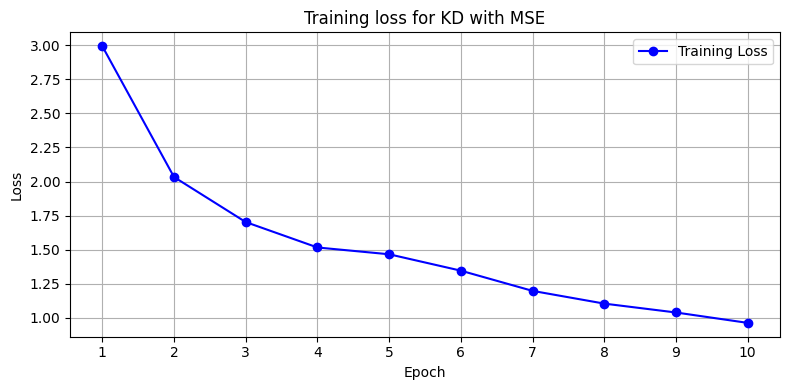

In [75]:
plot_loss(loss_MSE,"Training loss for KD with MSE")

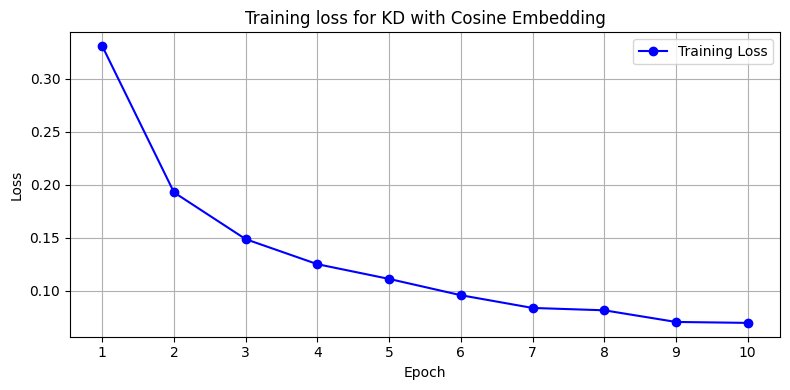

In [76]:
plot_loss(losses_COS,"Training loss for KD with Cosine Embedding")

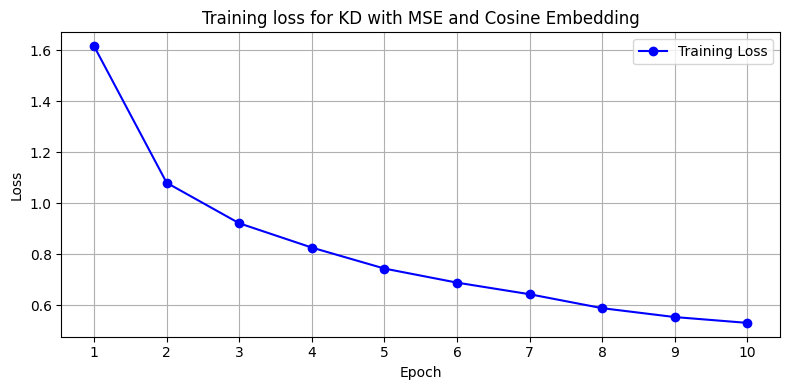

In [77]:
plot_loss(losses_combined,"Training loss for KD with MSE and Cosine Embedding")